In [1]:
import numpy as np

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.params import Default, NumberParam
from nengo.dists import Uniform
from nengo.neurons import *
from nengo.builder.neurons import *
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.base import ObjView
from nengo.builder import Builder, Operator, Signal
from nengo.exceptions import BuildError
from nengo.builder.connection import build_decoders, BuiltConnection
from nengo.utils.builder import full_transform

from nengolib.signal import s, z, nrmse, LinearSystem
from nengolib import Lowpass, DoubleExp

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

import time

import neuron

In [2]:
class DurstewitzNeuron(NeuronType):
    
    probeable = ('spikes', 'voltage')

    def __init__(self, v0=-65.0, dt_neuron=0.025):
        super(DurstewitzNeuron, self).__init__()
        self.v0 = v0
        self.dt_neuron = dt_neuron
        neuron.h.load_file('./NEURON/durstewitz/durstewitz.hoc')
        neuron.h.load_file('stdrun.hoc')

    def gain_bias(self, max_rates, intercepts):
#         gain = np.random.uniform(0, 1e-12, size=max_rates.shape)
#         bias = np.random.uniform(0, 0, size=max_rates.shape)
#         return gain, bias
        max_rates = np.array(max_rates, dtype=float, copy=False, ndmin=1)
        intercepts = np.array(intercepts, dtype=float, copy=False, ndmin=1)
        J_steps = 30
        max_rate = max_rates.max()
        # Find range of J that will achieve max rates (assume monotonic)
        J_threshold = None
        J_max = None
        Jr = 1.0  # test currents in namps
        for _ in range(10):
            J_test = np.linspace(0, Jr, J_steps)
            rate = self.rates(J_test, np.ones(J_steps), np.zeros(J_steps))
            if J_threshold is None and (rate <= 0).any():
                J_threshold = J_test[np.where(rate <= 0)[0][-1]]
            if J_max is None and (rate >= max_rate).any():
                J_max = J_test[np.where(rate >= max_rate)[0][0]]
            if J_threshold is not None and J_max is not None:
                break
            else:
                Jr *= np.sqrt(10)
        else:
            if J_threshold is None:
                raise RuntimeError("Could not find firing threshold")
            if J_max is None:
                raise RuntimeError("Could not find max current")
        J = np.linspace(J_threshold, J_max, J_steps)
        rate = self.rates(J, np.ones(J_steps), np.zeros(J_steps))
        gain = np.zeros_like(max_rates)
        bias = np.zeros_like(max_rates)
        J_tops = np.interp(max_rates, rate, J)
        gain[:] = (J_threshold - J_tops) / (intercepts - 1)
        bias[:] = J_tops - gain
#         print('gain', gain)
#         print('bias', bias)
        return gain, bias

    def max_rates_intercepts(self, gain, bias):
#         max_rates = np.random.uniform(0, 1e-12, size=gain.shape)
#         intercepts = np.random.uniform(0, 0, size=gain.shape)
#         return max_rates, intercepts
        max_rates = self.rates(np.ones_like(gain), gain, bias)
        x_range = np.linspace(-1, 1, 101)
        rates = np.asarray([self.rates(np.ones_like(gain) * x, gain, bias) for x in x_range])
        last_zeros = np.maximum(np.argmax(rates > 0, axis=0) - 1, 0)
        intercepts = x_range[last_zeros]
        return max_rates, intercepts
    
    def rates(self, x, gain, bias):
        """Estimates steady-state firing rate given gain and bias."""
        print("Estimating firing rates in response to somatic patch clamp...")
        J_test = self.current(x, gain, bias)
        n_neurons = gain.shape[0]
        spike_counts = np.zeros((n_neurons))
        settle_time = 0.3  # allow adaptive effects to kick in before recording spikes
        sim_time = 2.0
        dt = 0.001  # dt_nengo
        neuron.h.dt = self.dt_neuron
        neurons = []
#         volt_recs = []
#         time_recs = []
        spk_vecs = []
        spk_recs = []
#         soma_stims = []
        basal_stims = []
        prox_stims = []
        dist_stims = []
        for n in range(n_neurons):
            neurons.append(neuron.h.Durstewitz())
            neurons[n].init()  # build morphology
#             time_recs.append(neuron.h.Vector())
#             time_recs[n].record(neuron.h._ref_t)
#             volt_recs.append(neuron.h.Vector())
#             volt_recs[n].record(neurons[n].soma(0.5)._ref_v)
            spk_vecs.append(neuron.h.Vector())
            spk_recs.append(neuron.h.APCount(neurons[n].soma(0.5)))
            spk_recs[n].record(neuron.h.ref(spk_vecs[n]), dt*1000)
#             soma_stims.append(neuron.h.IClamp(neurons[n].soma(0.5)))
#             soma_stims[n].dur = (settle_time+sim_time)*1000
#             soma_stims[n].amp = J_test[n]
            basal_stims.append(neuron.h.IClamp(neurons[n].basal(0.5)))
            basal_stims[n].dur = (settle_time+sim_time)*1000
            basal_stims[n].amp = J_test[n]
            prox_stims.append(neuron.h.IClamp(neurons[n].prox(0.5)))
            prox_stims[n].dur = (settle_time+sim_time)*1000
            prox_stims[n].amp = J_test[n]
            dist_stims.append(neuron.h.IClamp(neurons[n].dist(0.5)))
            dist_stims[n].dur = (settle_time+sim_time)*1000
            dist_stims[n].amp = J_test[n]
        neuron.h.tstop = (settle_time+sim_time)*1000
        neuron.h.run()
        spike_counts = [np.where(np.array(sts) > settle_time*1000)[0].shape[0] for sts in spk_vecs]
        for n in range(n_neurons):
            spk_vecs[n].play_remove()
            del(neurons[0])
        print('J', J_test)
        print('Firing Rate', np.array(spike_counts)/sim_time)
        return np.array(spike_counts)/sim_time
    
    def step_math(self, J, stims, v_recs, spk_vecs, spk_recs, voltage, spiked, dt):
        n_neurons = J.shape[0]
        spk_before = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        for n in range(n_neurons):
            for stim in stims:
                stim[n].amp = J[n]
        neuron.h.tstop += dt*1000
        neuron.h.continuerun(neuron.h.tstop)
        voltage[:] = np.array([v[-1] for v in v_recs]).clip(-100, 60)
        spk_after = np.array([np.array(spk_vecs[n]) for n in range(n_neurons)])
        for n in range(n_neurons):
            spiked[n] = (len(np.array(spk_after[n])) - len(np.array(spk_before[n]))) / dt

class SimNeuronNeurons(Operator):
    def __init__(self, neuron_type, neurons, J, output, states):
        super(SimNeuronNeurons, self).__init__()
        self.neuron_type = neuron_type
        self.neurons = neurons
        self.reads = [states[0], J]
        self.sets = [output, states[1]]
        self.updates = []
        self.incs = []
#         self.t_recs = []
        self.v_recs = []
        self.spk_vecs = []
        self.spk_recs = []
#         self.soma_stims = []
        self.basal_stims = []
        self.prox_stims = []
        self.dist_stims = []
        for n in range(len(neurons)):
            self.neurons[n].init()
#             self.t_recs.append(neuron.h.Vector())
#             self.t_recs[n].record(neuron.h._ref_t)
            self.v_recs.append(neuron.h.Vector())
            self.v_recs[n].record(self.neurons[n].soma(0.5)._ref_v, dt*1000)
            self.spk_vecs.append(neuron.h.Vector())
            self.spk_recs.append(neuron.h.APCount(self.neurons[n].soma(0.5)))
            self.spk_recs[n].record(neuron.h.ref(self.spk_vecs[n]), dt*1000)
#             self.soma_stims.append(neuron.h.IClamp(self.neurons[n].soma(0.5)))
#             self.soma_stims[n].dur = 100*1000
#             self.soma_stims[n].amp = 0
            self.basal_stims.append(neuron.h.IClamp(self.neurons[n].basal(0.5)))
            self.basal_stims[n].dur = 100*1000
            self.basal_stims[n].amp = 0
            self.prox_stims.append(neuron.h.IClamp(self.neurons[n].prox(0.5)))
            self.prox_stims[n].dur = 100*1000
            self.prox_stims[n].amp = 0
            self.dist_stims.append(neuron.h.IClamp(self.neurons[n].dist(0.5)))
            self.dist_stims[n].dur = 100*1000
            self.dist_stims[n].amp = 0
#         self.stims = [self.soma_stims]
        self.stims = [self.basal_stims, self.prox_stims, self.dist_stims]
        neuron.h.dt = self.neuron_type.dt_neuron
        neuron.h.tstop = 0
#         neuron.h.init()

    def make_step(self, signals, dt, rng):
        J = signals[self.current]
        output = signals[self.output]
        voltage = signals[self.voltage]
        time = signals[self.time]
        def step_nrn():
            self.neuron_type.step_math(
                J, self.stims, self.v_recs, self.spk_vecs, self.spk_recs, voltage, output, dt)
        return step_nrn

    @property
    def time(self):
        return self.reads[0]
    @property
    def current(self):
        return self.reads[1]
    @property
    def output(self):
        return self.sets[0]
    @property
    def voltage(self):
        return self.sets[1]
    
@Builder.register(DurstewitzNeuron)
def build_neuronneuron(model, neuron_type, neurons):
    cells = [neuron.h.Durstewitz() for n in range(neurons.size_in)]
    model.sig[neurons]['voltage'] = Signal(
        neuron_type.v0*np.ones(neurons.size_in), name="%s.voltage"%neurons)
    neuronop = SimNeuronNeurons(
        neuron_type=neuron_type,
        neurons=cells,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.time, model.sig[neurons]['voltage']])
    model.params[neurons] = cells
    model.add_op(neuronop)


class TransmitSpikes(Operator):
    def __init__(self, neurons, synapses, weights, netstims, spikes, states):
        super(TransmitSpikes, self).__init__()
        self.neurons = neurons
        self.synapses = synapses
        self.weights = weights
        self.netstims = netstims
        self.time = states[0]
        self.reads = [spikes, states[0]]
        self.updates = []
        self.sets = []
        self.incs = []
        
        self.netcons = np.zeros((self.weights.shape), dtype=list)
        for pre in range(self.synapses.shape[0]):
            for post in range(self.synapses.shape[1]):
                # NetCon(source, target, threshold, delay, weight)
                self.netcons[pre, post] = []
                for compt in range(len(self.synapses[pre, post])):
                    stim = self.netstims[pre, post][compt]
                    syn = self.synapses[pre, post][compt]
                    w = abs(self.weights[pre, post])
                    nc = neuron.h.NetCon(stim, syn, 0, 0, w)
                    self.netcons[pre, post].append(nc)
        neuron.h.init()

    def make_step(self, signals, dt, rng):
        spikes = signals[self.spikes]
        time = signals[self.time]
        def step():
            t_neuron = time.item()*1000
            for pre in range(spikes.shape[0]):
                if spikes[pre] > 0:
                    for post in range(len(self.neurons)):
                        for nc in self.netcons[pre, post]:
                            nc.pre().number = 1
                            nc.pre().start = t_neuron
        return step

    @property
    def spikes(self):
        return self.reads[0]


@Builder.register(nengo.Connection)
def build_connection(model, conn):
    rng = np.random.RandomState(model.seeds[conn])
    if isinstance(conn.post_obj, nengo.Ensemble) and isinstance(conn.post_obj.neuron_type, DurstewitzNeuron):

        assert isinstance(conn.pre_obj, nengo.Ensemble), "only presynaptic neurons supported"
        assert 'spikes' in conn.pre_obj.neuron_type.probeable, "only spiking neurons supported"
        assert isinstance(conn.synapse, LinearSystem), "only nengolib synapses supported"
        assert len(conn.synapse.num) == 0, "only poles supported"

        model.sig[conn]['in'] = model.sig[conn.pre_obj]['out']
        neurons = model.params[conn.post_obj.neurons]
        transform = full_transform(conn, slice_pre=False)
        eval_points, d, solver_info = model.build(conn.solver, conn, rng, transform)
        enc = model.params[conn.post_obj].scaled_encoders.T[conn.post_slice]
        weights = np.dot(d.T, enc)

        taus = -1.0/np.array(conn.synapse.poles)
        synapses = np.zeros((weights.shape), dtype=list)
        netstims = np.zeros((weights.shape), dtype=list)
        E_exc = 0.0  # reversal potential for excitatory synapses in mV
        E_inh = -70.0  # reversal potential for inhibitory synapses in mV

        for pre in range(synapses.shape[0]):
            for post in range(synapses.shape[1]):
                if len(taus) == 1:
#                     syn = neuron.h.ExpSyn(neurons[post].soma(0.5))
#                     syn.tau = taus[0]*1000
                    syn_basal = neuron.h.ExpSyn(neurons[post].basal(0.5))
                    syn_basal.tau = taus[0]*1000
                    syn_prox = neuron.h.ExpSyn(neurons[post].prox(0.5))
                    syn_prox.tau = taus[0]*1000
                    syn_dist = neuron.h.ExpSyn(neurons[post].dist(0.5))
                    syn_dist.tau = taus[0]*1000
                elif len(taus) == 2:
#                     syn = neuron.h.Exp2Syn(neurons[post].soma(0.5))
#                     syn.tau1 = taus[0]*1000
#                     syn.tau2 = taus[1]*1000
                    syn_basal = neuron.h.Exp2Syn(neurons[post].basal(0.5))
                    syn_basal.tau1 = taus[0]*1000
                    syn_basal.tau2 = taus[1]*1000
                    syn_prox = neuron.h.Exp2Syn(neurons[post].prox(0.5))
                    syn_prox.tau1 = taus[0]*1000
                    syn_prox.tau2 = taus[1]*1000
                    syn_dist = neuron.h.Exp2Syn(neurons[post].dist(0.5))
                    syn_dist.tau1 = taus[0]*1000
                    syn_dist.tau2 = taus[1]*1000
                if weights[pre, post] > 0:
#                     syn.e = E_exc
                    syn_basal.e = E_exc
                    syn_prox.e = E_exc
                    syn_dist.e = E_exc
                elif weights[pre, post] < 0:
#                     syn.e = E_inh
                    syn_basal.e = E_inh
                    syn_prox.e = E_inh
                    syn_dist.e = E_inh
#                 synapses[pre, post] = [syn]
                synapses[pre, post] = [syn_basal, syn_prox, syn_dist]
#                 netstims[pre, post] = [neuron.h.NetStim()]
                netstims[pre, post] = [neuron.h.NetStim(), neuron.h.NetStim(), neuron.h.NetStim()]
                for ns in netstims[pre, post]:
                    ns.start = 0
                    ns.number = 0
                    ns.interval = 0
                    ns.noise = 0

        model.add_op(TransmitSpikes(
            neurons, synapses, weights, netstims, model.sig[conn.pre_obj]['out'], states=[model.time]))
        model.params[conn] = BuiltConnection(
            eval_points=eval_points, solver_info=solver_info, transform=transform, weights=d)
    else:
        return nengo.builder.connection.build_connection(model, conn)

/home/pduggins/nengo/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


# Control Structure

In [3]:
def norms(freq, amp, seed, tau, t, dt):
    lpf=nengo.Lowpass(tau)
    with nengo.Network() as model:
        stim = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
        p_stim = nengo.Probe(stim, synapse=None)
        p_integral = nengo.Probe(stim, synapse=1/s)
    with nengo.Simulator(model, progress_bar=False, dt=dt, seed=seed) as sim:
        sim.run(t, progress_bar=False)
    stimulus = lpf.filt(sim.data[p_stim], dt=dt, y0=0)
    target = sim.data[p_integral]
    target_f = lpf.filt(sim.data[p_integral], dt=dt, y0=0)
    norm_s = np.max(np.abs(stimulus))
    norm = np.max(np.abs(target))
    norm_f = np.max(np.abs(target_f))
    return norm, norm_s, norm_f

def go(n_neurons, neuron_type, t, dt, d,
       tau=0.01, max_rates=Uniform(30, 60), freq=1, amp=1, seed=0, seed2=1):
    norm, norm_s, norm_f = norms(freq, amp, seed, tau, t, dt)
    with nengo.Network() as model:
        u_raw = nengo.Node(nengo.processes.WhiteSignal(period=t, high=freq, rms=amp, seed=seed))
        stim = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        target = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        pre = nengo.Ensemble(100, 1, seed=seed2, neuron_type=nengo.LIF())
        x = nengo.Ensemble(n_neurons, 1, 
            neuron_type=neuron_type, max_rates=max_rates, seed=seed2, label='ens')
#         x2 = nengo.Ensemble(n_neurons, 1, seed=seed2, neuron_type=neuron_type, label='ens')
        post = nengo.Ensemble(n_neurons, 1, seed=seed2)
        nengo.Connection(u_raw, stim, transform=1./norm_s, synapse=None, seed=seed2)
        nengo.Connection(stim, pre, synapse=None, seed=seed2)
#         pre_x2 = nengo.Connection(pre, x2, synapse=DoubleExp(0.001, tau), transform=1, seed=seed2)
        pre_x = nengo.Connection(pre, x, synapse=Lowpass(tau), transform=1, seed=seed2)
#         pre_x = nengo.Connection(pre, x, synapse=DoubleExp(0.001, tau), transform=1, seed=seed2)
#         pre_x = nengo.Connection(pre, x, synapse=LinearSystem(([], [0.001, tau], 0.001*tau)), transform=1, seed=seed2)
        nengo.Connection(stim, target, synapse=None, seed=seed2)
        x_post = nengo.Connection(x, post, synapse=tau, solver=NoSolver(d), seed=seed2)
#         x_x = nengo.Connection(x, x, synapse=tau, solver=NoSolver(d), seed=3)
#         x_x = nengo.Connection(x, x, synapse=Lowpass(tau), solver=NoSolver(d), seed=3)
#         x_x = nengo.Connection(x, x, synapse=DoubleExp(0.001, tau), solver=NoSolver(d), seed=seed2)
        p_tar = nengo.Probe(target, synapse=tau)
        p_pre_s = nengo.Probe(pre.neurons, 'spikes', synapse=None)
        p_s = nengo.Probe(x.neurons, 'spikes', synapse=None)
        p_v = nengo.Probe(x.neurons, 'voltage', synapse=None)
        p_post = nengo.Probe(post, synapse=tau)
    
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(t)

    return sim.trange(), sim.data[p_tar], sim.data[p_pre_s], sim.data[p_s], sim.data[p_v], sim.data[p_post]

# Simulations

## Communication Channel

	1 


/home/pduggins/.virtualenvs/nbn/lib/python3.6/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Estimating firing rates in response to somatic patch clamp...
J [0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]
Firing Rate [ 0.   4.  15.5 22.  27.5 31.5 35.5 39.  41.5 44.5 46.  47.5 49.   3.
 51.  52.  52.5 53.5 54.  55.  55.  56.  56.5 57.5 58.  58.  59.  59.5
 60.  61. ]
Estimating firing rates in response to somatic patch clamp...
J [0.         0.0059453  0.01189061 0.01783591 0.02378121 0.02972652
 0.03567182 0.04161712 0.04756243 0.05350773 0.05945303 0.06539834
 0.07134364 0.07728894 0.08323424 0.08917955 0.09512485 0.10107015
 0.10701546 0.11296076 0.11890606 0.12485137 0.13079667 0.13674197
 0.14268728 0.14863258 0.15457788 0.16052319 0.16646849 0.17241379]
Firing Rate [ 0.   0.   0.   0.5  0.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

simulated 1 sim seconds with 10 neurons in 41.55738067626953 real seconds


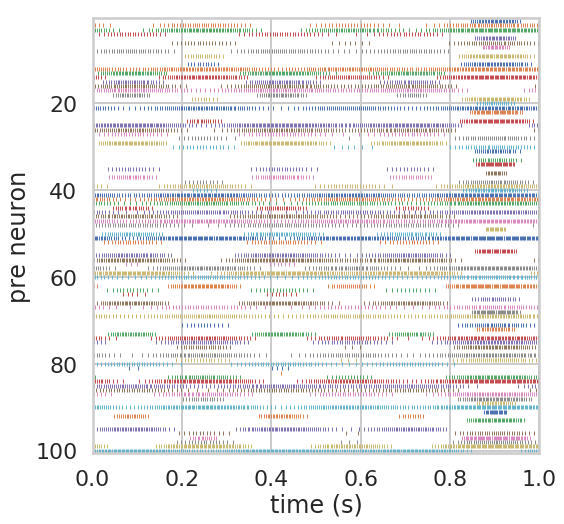

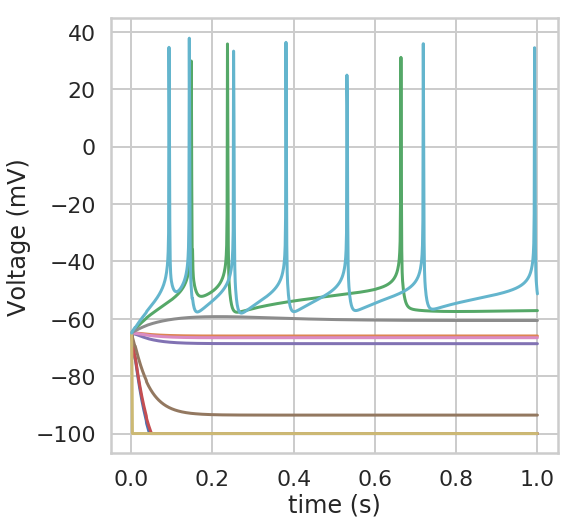

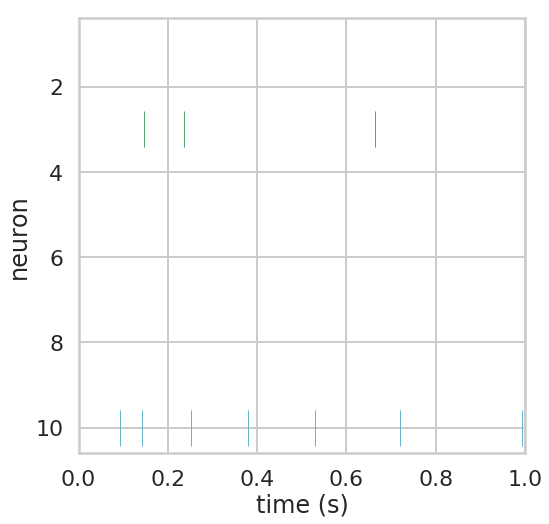

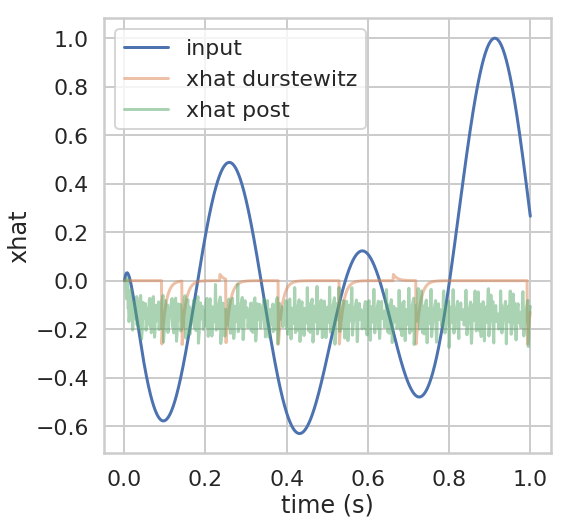

In [4]:
reg = 0.1
n_neurons = 10
tau = 0.01
d = np.zeros((n_neurons, 1))
seed = 0
rates = Uniform(10, 30)
t = 1
dt = 0.001
dt_neuron = 0.025  # ms
freq = 3
neuron_type = DurstewitzNeuron(dt_neuron=dt_neuron)

start = time.time()

t0, tar0, pres0, s0, v0, post0 = go(n_neurons, t=t, dt=dt, d=d, max_rates=rates,
    neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

end = time.time()

print("simulated %s sim seconds with %s neurons in %s real seconds" %(t, n_neurons, end-start))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, pres0)
ax.set(xlabel='time (s)', ylabel='pre neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, v0)
ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
plt.show()

a0 = nengo.Lowpass(tau).filt(s0)
d = LstsqL2(reg=reg)(a0, tar0)[0]
xhat0 = np.dot(a0, d)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
rasterplot(t0, s0)
ax.set(xlabel='time (s)', ylabel='neuron')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(t0, tar0, label='input')
ax.plot(t0, xhat0, label='xhat durstewitz', alpha=0.5)
ax.plot(t0, post0, label='xhat post', alpha=0.5)
ax.legend()
ax.set(xlabel='time (s)', ylabel='xhat')
plt.show()

1s 10 neurons no synapses 18 min

In [5]:
# t1, tar1, pres1, s1, v1, post1 = go(n_neurons, t=t, dt=dt, d=d,
#     neuron_type=neuron_type, freq=freq, tau=tau, seed=seed)

# a1 = nengo.Lowpass(tau).filt(s1)
# xhat1 = np.dot(a1, d)

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.plot(t1, v1/mV)
# ax.set(xlabel='time (s)', ylabel='Voltage (mV)')
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# rasterplot(t1, s1)
# ax.set(xlabel='time (s)', ylabel='neuron')
# plt.show()

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.plot(t1, tar1, label='input')
# ax.plot(t1, xhat1, label='xhat durstewitz', alpha=0.5)
# ax.plot(t1, post1, label='xhat post', alpha=0.5)
# ax.legend()
# ax.set(xlabel='time (s)', ylabel='xhat')
# plt.show()

In [6]:
# filename = 'data/durstewitz_cc.npz'
# np.savez(filename, t1=t1, tar1=tar1, pres1=pres1, s1=s1, v1=v1, post1=post1)